In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import functools
import csv
from scipy.optimize import minimize

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, build_cov_mat, lognormpdf, plot_bivariate_gauss, eval_func_on_grid

def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)

# Precision Assessment of Attitude Measurement Devices of Spacecrafts
### Final Project of AEROSP 567, University of Michigan

Author: Hung-Hsiang Liang

A Bayesian covariance matrix assessment method of attitude measurement devices of spacecrafts is presented in this paper. The Bayesian inference model (posterior) is established by an inverse Wishart prior and a Gaussian lieklihood which incorporates the experimental measurement data. Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC) with random walk proposal is used to sample from the posterior and obtain the estimation of the covariance matrix. Further diagnoses of MCMC show that the proposed assessment method can provide simulations with good mixing, rapid convergence, and high efficiency.

## Prior, Likelihood, and Posterior
### Prior
The prior is inverse Wishart distribution

\begin{equation}\label{eqn:inv_wishart}
    f_{\mathbf{\Sigma}} \triangleq p(\mathbf{\Sigma}) = \frac{|\mathbf{V}|^{m/2} |\mathbf{\Sigma}|^{-(m+p+1)/2} \exp\left[ -tr(\mathbf{V\Sigma^{-1}})/2 \right]}{2^{mp/2} \Gamma(m/2)}
\end{equation}

### Likelihood
The likelihood is 

\begin{align*}
    \mathcal{L}(\mathbf{\Sigma|D}) &\propto f_{\mathbf{D}|\Sigma} \propto |\mathbf{\Sigma}|^{-n/2} \exp \left( -\frac{1}{2} \sum_{i=1}^{n} \mathbf{x}_i^T \mathbf{\Sigma}^{-1} \mathbf{x}_i \right) \\
    & = |\mathbf{\Sigma}|^{-n/2} \exp \left[ -\frac{1}{2} tr \left( \sum_{i=1}^{n} \mathbf{x}_i\mathbf{x}_i^T \mathbf{\Sigma}^{-1}  \right)\right] \\
    & = |\mathbf{\Sigma}|^{-n/2} \exp \left[ -\frac{n}{2} tr \left( \mathbf{S} \mathbf{\Sigma}^{-1}  \right)\right] \label{eqn:likelihood}
\end{align*}

### Posterior
And the posterior is 

\begin{align*}
    f_{\mathbf{\Sigma|D}} \propto &|\mathbf{\Sigma}|^{-n/2} \exp \left[ -\frac{n}{2} tr \left( \mathbf{S} \mathbf{\Sigma}^{-1}  \right)\right]\\ &|\mathbf{\Sigma}|^{-(m+p+1)/2} \exp\left[ -tr(\mathbf{V\Sigma^{-1}})/2 \right]\\
    = &|\mathbf{\Sigma}|^{-(n+m+p+1)/2}\exp \{ -\frac{1}{2} tr \left[ \left( n\mathbf{S} + \mathbf{V} \right) \mathbf{\Sigma}^{-1}  \right]\} \label{eqn:posterior}
\end{align*}

### Acceptance Probability
The acceptance probability is
\begin{equation}
a(x^{(k)}, y) = \min \left\{ \frac{f_X(y)}{f_X(x^{(k)})} \frac{q(x^{(k)} \mid y)}{q(y \mid x^{(k)})}, \  1 \right\}
\end{equation}

The log-pdfs form is

\begin{equation}
\tilde{a}(x^{(k)}, y) = \min \left\{ \log f_X(y) - \log f_X(x^{(k)}) + \log q(x^{(k)} \mid y) - \log q(y \mid x^{(k)}), \  0 \right\}
\end{equation}

In [2]:
def mh_acceptance_prob(current_target_logpdf,proposed_target_logpdf, current_sample, proposed_sample, proposal_func):
    """Compute the metropolis-hastings accept-reject probability
    
    Inputs
    ------
    current_target_logpdf : float, logpdf at the current sample in the chain f_X(x^{(k)})
    proposed_target_logpdf : float, logpdf at the proposed sample in the chain
    current_sample : (d, ), current sample
    proposed_sample : (d, ), proposed sample
    proposal_func: f(x, y) callable that gives the log probability of y given x
    
    Returns
    -------
    acceptance probability
    """
    
    prop_reverse = proposal_func(proposed_sample, current_sample)
    prop_forward = proposal_func(current_sample, proposed_sample)
    
    check = proposed_target_logpdf - current_target_logpdf + prop_reverse - prop_forward
    
    if check < 0:
        return np.exp(check)
    else:
        return 1        

### Extract sample & reform sample

Because our samples are 2-by-2 covariance matrice, where the secondary diagonal elements are identical, only 3 elements need to be learned. Therefore, the "extract_sample" function extract 3 out of 4 elements for learning, and the "reform_sample" reforms a sample from 3-by-1 vector to 2-by-2 matrix.

In [3]:
def extract_sample(sample):
    '''
    Inputs
    ------
    sample: (2, 2) samples
    
    Outputs
    ------
    y: (3, 1) samples
    '''
    return np.array([[sample[0, 0]], [sample[0, 1]], [sample[1, 1]]])

In [4]:
def reform_sample(y):
    '''
    Inputs
    ------
    y: (3, 1) samples
    
    Outputs
    ------
    sample: (2, 2) samples
    '''
    return np.array([[y[0, 0], y[1, 0]], [y[1, 0], y[2, 0]]] )

## Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC)

To sample from the posterior, MH-MCMC is proposed. According to Professor Gorodetsky's lecture note, the main steps of MH-MCMC are as follows:

1. Set initial state $\mathbf{\Sigma}^{(0)}$.

2. Sample from a proposal distribution to obtain new proposed state:

\begin{equation}
    \mathbf{v}_{\mathbf{\Sigma}^{(k+1)-}} \sim q(\mathbf{v}_{\mathbf{\Sigma}^{(k+1)-}}|\mathbf{v}_{\mathbf{\Sigma}^{(k)}})
\end{equation}
where 
\begin{equation}\label{eqn:sigma_vec}
        \mathbf{v}_{\mathbf{\Sigma}^{(k)}} \triangleq \left[ \Sigma^{(k)}_{11}, \Sigma^{(k)}_{12}, \Sigma^{(k)}_{22} \right]^T
\end{equation}
This is valid due to the fact that $\Sigma^{(k)}_{12} = \Sigma^{(k)}_{21}$.

3. Compute the acceptance probability of propagation from $\mathbf{\Sigma}^{(k)}$ to $\mathbf{\Sigma}^{(k+1)-}$:

\begin{align*}
    a(&\mathbf{\Sigma}^{(k)}, \mathbf{\Sigma}^{(k+1)-}) = \\
    &\min \left(1, \frac{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma}^{(k+1)-}) } {f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma}^{(k)}) } \frac{q(\mathbf{v}_{\mathbf{\Sigma}^{(k)}}| \mathbf{v}_{\mathbf{\Sigma}^{(k+1)-}})} {q(\mathbf{v}_{\mathbf{\Sigma}^{(k+1)-}}| \mathbf{v}_{\mathbf{\Sigma}^{(k)}})}\right)
    \label{eqn:acceptance}
\end{align*}

4. Accept or reject proposed state:

\begin{equation}
\mathbf{\Sigma}^{(k+1)}=
    \begin{cases}
        \mathbf{\Sigma}^{(k+1)-} \text{ with probability } a(\mathbf{\Sigma}^{(k)}, \mathbf{\Sigma}^{(k+1)-})\\
        \mathbf{\Sigma}^{(k)} \text{ otherwise}
    \end{cases}
\end{equation}

5. Repeat step 2 to step 4.

In [5]:
def mhmcmc(starting_sample, num_samples, target_logpdf, proposal_logpdf, proposal_sampler):
    """Metropolis-Hastings MCMC
    
    Inputs
    ------
    starting_sample: (d, d) the initial sample
    num_sample: positive integer, the number of total samples
    target_logpdf: function(x) -> logpdf of the target distribution
    proposal_logpdf: function (x, y) -> logpdf of proposing y if current sample is x
    proposal_sampler: function (x) -> y, generate a sample if you are currently at x
    
    Returns
    -------
    Samples: (num_samples, d) array of samples
    accept_ratio: ratio of proposed samples that were accepted
    """

    d = starting_sample.shape[0]
    samples = np.zeros((num_samples, d, d))
    samples[0, :, :] = starting_sample
    current_target_logpdf = target_logpdf(samples[0, :, :])
    
    num_accept = 0
    for ii in range(1, num_samples):
        # propose
        
        sample_vector = extract_sample(samples[ii-1, :, :])
        proposed_sample_vector = proposal_sampler(sample_vector)
        proposed_sample = reform_sample(proposed_sample_vector)
        
        # determine acceptance probability
        if np.linalg.det(proposed_sample) <= 0 or proposed_sample[0, 0] <= 0 or proposed_sample[1, 1] <= 0:
            a = 0 # if the proposed_sample is not positive definite, reject anyway
        else:
            proposed_target_logpdf = target_logpdf(proposed_sample)
            a = mh_acceptance_prob(current_target_logpdf, proposed_target_logpdf, sample_vector, proposed_sample_vector, proposal_logpdf)
        
        # Accept or reject the sample
        if a == 1: #guaranteed to accept
            samples[ii, :, :] = proposed_sample
            current_target_logpdf = proposed_target_logpdf
            num_accept += 1
        else:
            u = np.random.rand()
            if u < a: # accept
                samples[ii, :, :] = proposed_sample
                current_target_logpdf = proposed_target_logpdf
                num_accept += 1
            else: # reject
                samples[ii, :, :] = samples[ii-1, :, :]
                
    return samples, num_accept / float(num_samples-1)

### Read data and plot the distribution

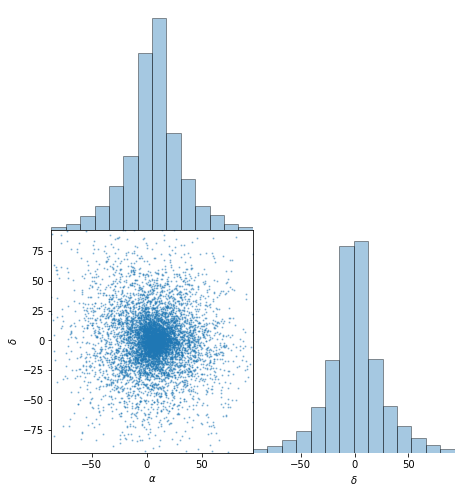

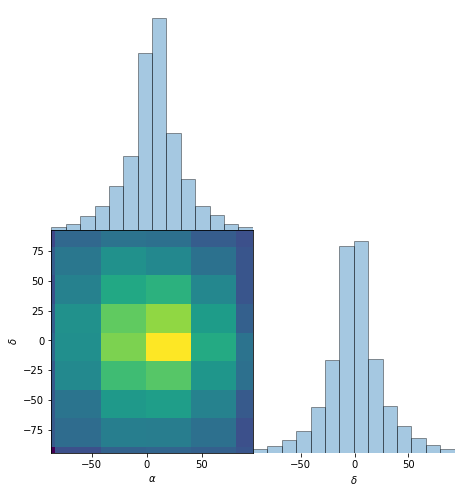

In [6]:
#num_data = 100000
#dim = 2
#data = gauss_mean + np.random.randn(num_data, 2) # random location
#data = np.einsum('ij,kj->ki', np.linalg.cholesky(gauss_cov), data)

with open('Data.csv', 'r', encoding='utf-8-sig') as dest_f:
    data_iter = csv.reader(dest_f,
                           delimiter = ',',
                           quotechar = '"')
    data = [data for data in data_iter]
data = np.asarray(data, np.float32)
data = data * 3600 # convert to arcsec
num_data = data.shape[0]
dim = data.shape[1]
data_mean = np.mean(data, axis=0)

fig, axs, gs = scatter_matrix([data], labels=[r'$\alpha$', r'$\delta$'], 
                              hist_plot=False, gamma=0.4)
fig.set_size_inches(7,7)
fig, axs, gs = scatter_matrix([data], labels=[r'$\alpha$', r'$\delta$'], 
                              hist_plot=True, gamma=0.2,
                                 nbins=70)
fig.set_size_inches(7,7)
plt.show()

### The log likelihood function

In [7]:
def log_likelihood(Sigma, diff):
    
    d, N = diff.shape
    
    preexp = (-d/2) * np.log (2.0 * np.pi) - (N/2) * np.log(np.linalg.det(Sigma))
    sol = np.linalg.solve(Sigma, diff)
    inexp = diff * sol
    inexp = np.sum(inexp)
    
    out = preexp - 0.5 * inexp
    
    return out
    

### The log prior function (log inverse wishart pdf)

In [8]:
def log_inverse_wishart_pdf(Sigma, dof, Lambda):
    
    '''
    Inputs
    ------
    Sigma: (d, d), covariance matrix sample
    dof: int, degree of freedom for a dxd covariance matrix
    Lambda: (d, d), scale matrix
    
    Outputs
    ------
    preexp + inexp: float, log-probability
    '''
    
    d = Sigma.shape[0]
    preexp = (-(dof + d +1)/2) * np.log(np.linalg.det(Sigma))
    inexp = -0.5*np.trace(Lambda*np.linalg.inv(Sigma))
    
    return preexp + inexp
    

### Random walk proposal and their samplers for MCMC

In [9]:
def proposal_rw_sampler(x, cov):
    """Sample from a random walk proposal with identity covariance"""
    y = np.dot(np.linalg.cholesky(cov), np.random.randn(x.shape[0], 1)) + x
    return y

def proposal_rw_logpdf(x, y, cov):
    """Probability of moving from x to y (in this case it is symmetric)"""
    delta = x - y
    d = delta.shape[0]
    
    preexp = 1.0 / (2.0 * np.pi)**(d/2) / np.linalg.det(cov)**(1/2)
    sol = np.linalg.solve(cov, delta)
    inexp = -0.5 * np.dot(delta.T, sol)
    logpdf = np.log(preexp) + inexp
    
    return logpdf

### Laplace approximation
To improve the efficiency of the MH-MCMC, we implement Laplace approximation to approximate the posterior with a Gaussian distribution and generate an initial sample and the covariance. The Taylor expansion around some point $\mathbf{v}_{\mathbf{\Sigma}}^*$ so that any $\mathbf{v}_{\mathbf{\Sigma}}=\mathbf{v}_{\mathbf{\Sigma}}^* + \delta \mathbf{v}_{\mathbf{\Sigma}}$

\begin{align*}
    \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma})} = \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma}^*)} &+ \nabla \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma})}|_{\mathbf{\Sigma}=\mathbf{\Sigma}^*}\delta \mathbf{\Sigma} \\
    &+  \frac{1}{2} \Delta \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma})}|_{\mathbf{\Sigma}=\mathbf{\Sigma}^*}\delta \mathbf{\Sigma}^2 \\
                                  &+ H.O.T.
\end{align*}

If we choose $\mathbf{v}_{\mathbf{\Sigma}}^* = \mathbf{v}_{\mathbf{\Sigma}}^{MAP}$, then the second term of the equation above vanishes and we obtain

\begin{align*}
    \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma})} &\approx \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma}^{M.A.P})} \\
    &+ \frac{1}{2} \Delta \log{f_{\mathbf{\Sigma|D}}(\mathbf{\Sigma})} (\mathbf{\Sigma} - \mathbf{\Sigma}^{M.A.P})^2 
\end{align*}

In [10]:
def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation, 
        returning the MAP point and an approximation of the covariance
        
    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior
    
    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)
    
    bnds = ((0, None), (0, None), (0, None))
    # Gradient free method to obtain optimum
    res = minimize(neg_post, initial_guess, method='Nelder-Mead', bounds=bnds) 
    # Gradient method which also approximates the inverse of the hessian
    res = minimize(neg_post, res.x)
    
    map_point = res.x
    cov_approx = res.hess_inv

    return map_point, cov_approx

### Run MH-MCMC

In [11]:
dof = 3
num_samples = 200000

Lambda = np.eye(2)
data_diff = data - data_mean

print(np.sum(data_diff[:, 0]**2)/num_data)
print(np.sum(data_diff[:, 0]*data_diff[:, 1])/num_data)
print(np.sum(data_diff[:, 1]*data_diff[:, 0])/num_data)
print(np.sum(data_diff[:, 1]**2)/num_data)

initial_guess = np.eye(2)
target_log_pdf = lambda Sigma: log_likelihood(Sigma, diff=data_diff.T) + log_inverse_wishart_pdf(Sigma, dof=dof, Lambda=Lambda)
target_log_pdf_1d = lambda x: target_log_pdf(np.array([[x[0], x[1]], [x[1], x[2]]]))
[initial_sample, initial_cov] = laplace_approx(np.array([initial_guess[0, 0], initial_guess[0, 1], initial_guess[1, 1]]), target_log_pdf_1d)
print(initial_sample)
print(initial_cov)

initial_sample = np.array([[initial_sample[0], initial_sample[1]], [initial_sample[1], initial_sample[2]]])
prop_sampler = lambda x: proposal_rw_sampler(x, cov=500*np.eye(3))
prop_logpdf = lambda x, y: proposal_rw_logpdf(x, y, cov=500*np.eye(3))


samples, ar = mhmcmc(initial_sample, num_samples, target_log_pdf, 
                     prop_logpdf, prop_sampler)

print("Accepted Samples Ratio:", ar)

1354.2469417932518
291.03135502083614
291.03135502083614
973.8019895147197
[1353.15556107  290.79679554  973.01735671]
[[5.05330335 0.         5.02665168]
 [0.         1.         0.        ]
 [5.02665168 0.         5.01332584]]


/Users/Sean/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Accepted Samples Ratio: 0.29970649853249265


In [12]:
burnin = int(num_samples*0.1)

print(np.sum(samples[burnin:, 0, 0])/(num_samples-burnin))
print(np.sum(samples[burnin:, 0, 1])/(num_samples-burnin))
print(np.sum(samples[burnin:, 1, 0])/(num_samples-burnin))
print(np.sum(samples[burnin:, 1, 1])/(num_samples-burnin))

1354.2794801887721
290.94201409561583
290.94201409561583
973.8030675696627


## Diagnosis
### Visual inspection of mixing

Text(0.5, 0, 'Sample Number')

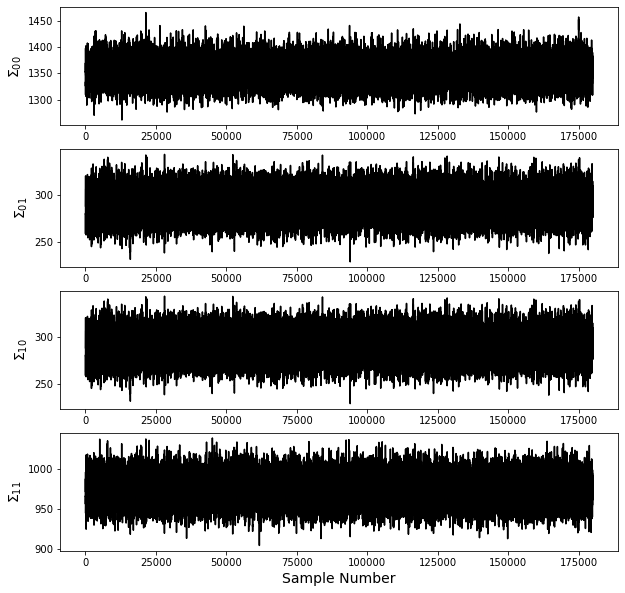

In [13]:
fig, axs = plt.subplots(4,1, figsize=(10,10))
axs[0].plot(samples[burnin:, 0, 0], '-k')
axs[0].set_ylabel(r'$\Sigma_{00}$', fontsize=14)
axs[1].plot(samples[burnin:, 0, 1], '-k')
axs[1].set_ylabel(r'$\Sigma_{01}$', fontsize=14)
axs[2].plot(samples[burnin:, 1, 0], '-k')
axs[2].set_ylabel(r'$\Sigma_{10}$', fontsize=14)
axs[3].plot(samples[burnin:, 1, 1], '-k')
axs[3].set_ylabel(r'$\Sigma_{11}$', fontsize=14)
axs[3].set_xlabel('Sample Number', fontsize=14)

### Autocorrelation
Autocorrelation $R(l)$ is defined as
\begin{align*}
    R(l) &= corr(\mathbf{v}_{\mathbf{\Sigma}^{(k)}}, \mathbf{v}_{\mathbf{\Sigma}^{(k+1)}})\\ 
    &= \frac{\sum_{i=0}^{n-l}
    (\mathbf{v}_{\mathbf{\Sigma}^{(i)}} - \bar{\mathbf{v}}_{\mathbf{\Sigma}})
    (\mathbf{v}_{\mathbf{\Sigma}^{(i+1)}} - \bar{\mathbf{v}}_{\mathbf{\Sigma}})}
    {\sum_{i=0}^{n}(\mathbf{v}_{\mathbf{\Sigma}^{(i)}} - \bar{\mathbf{v}}_{\mathbf{\Sigma}})^2}
\end{align*}

In [14]:
def autocorrelation(samples, maxlag=100, step=1):
    """Compute the correlation of a set of samples
    
    Inputs
    ------
    samples: (N, d)
    maxlag: maximum distance to compute the correlation for
    step: step between distances from 0 to maxlag for which to compute teh correlations
    """
    
    # Get the shapes
    ndim = samples.shape[1]
    nsamples = samples.shape[0]    
    
    # Compute the mean
    mean = np.mean(samples, axis=0)
    
    # Compute the denominator, which is variance
    denominator = np.zeros((ndim))
    for ii in range(nsamples):
        denominator = denominator + (samples[ii, :] - mean)**2
    
    lags = np.arange(0, maxlag, step)
    autos = np.zeros((len(lags), ndim))
    for zz, lag in enumerate(lags):
        autos[zz, :] = np.zeros((ndim))
        # compute the covariance between all samples *lag apart*
        for ii in range(nsamples - lag):
            autos[zz,:] = autos[zz, :] + (samples[ii,:]-mean)*(samples[ii + lag,:] -mean)
        autos[zz, :] = autos[zz, :]/denominator
    return lags, autos

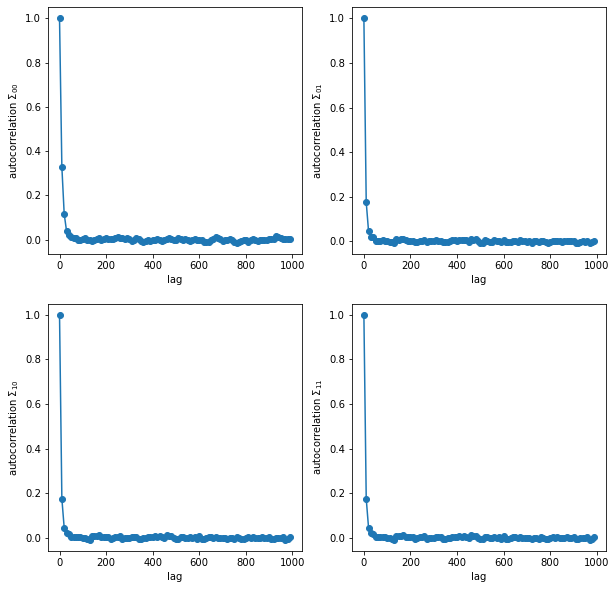

In [15]:
maxlag=1000
step=10
lags, autolag = autocorrelation(np.reshape(samples[burnin:], [num_samples-burnin, 4]), maxlag=maxlag, step=step)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(lags, autolag[:, 0],'-o')
axs[0, 0].set_xlabel('lag')
axs[0, 0].set_ylabel(r'autocorrelation $\Sigma_{00}$')
axs[0, 1].plot(lags, autolag[:, 1],'-o')
axs[0, 1].set_xlabel('lag')
axs[0, 1].set_ylabel(r'autocorrelation $\Sigma_{01}$')
axs[1, 0].plot(lags, autolag[:, 1],'-o')
axs[1, 0].set_xlabel('lag')
axs[1, 0].set_ylabel(r'autocorrelation $\Sigma_{10}$')
axs[1, 1].plot(lags, autolag[:, 1],'-o')
axs[1, 1].set_xlabel('lag')
axs[1, 1].set_ylabel(r'autocorrelation $\Sigma_{11}$')
plt.show()

### Integrated autocorrelation (IAC)
The integrated autocorrelation (IAC) is defined as
\begin{equation}
    IAC = 1 + 2\sum_{l=1}^{\infty}corr(f_{\mathbf{\Sigma|D}}(\mathbf{v}_{\mathbf{\Sigma}^{(0)}}), f_{\mathbf{\Sigma|D}}(\mathbf{v}_{\mathbf{\Sigma}^{(l)}})) = \theta
\end{equation}

In [16]:
IACx = 1 + 2 * np.sum(autolag[:, 0])
IACy = 1 + 2 * np.sum(autolag[:, 1])
IACz = 1 + 2 * np.sum(autolag[:, 2])
IACw = 1 + 2 * np.sum(autolag[:, 3])
print("IAC(x):", IACx)
print("IAC(y):", IACy)
print("IAC(z):", IACz)
print("IAC(w):", IACw)

IAC(x): 4.11932153248522
IAC(y): 3.5114259480128336
IAC(z): 3.5114259480128336
IAC(w): 3.829720690191596


### effective sample size (ESS)

The effective sample size (ESS) is defined as
\begin{equation}\label{eqn:ESS}
    ESS = \frac{n}{\theta}
\end{equation}

In [17]:
ESSx = (num_samples-burnin)/IACx
ESSy = (num_samples-burnin)/IACy
ESSz = (num_samples-burnin)/IACz
ESSw = (num_samples-burnin)/IACw
print("ESS(x):", ESSx)
print("ESS(y):", ESSy)
print("ESS(z):", ESSz)
print("ESS(w):", ESSw)

ESS(x): 43696.5161812471
ESS(y): 51261.22625535207
ESS(z): 51261.22625535207
ESS(w): 47000.81665511613
